# Synchronous States in Homogeneous Populations of LIF Neurons (MP2)

---
**Authors**: Emma Boehly, Linkai Dai \
**Course**: NX-465 Neuronal Dynamics, EPFL, Spring 2023

---

In [2]:
# start with importing the libraries we need
%matplotlib inline
import numpy as np
import brian2 as b2
import matplotlib.pyplot as plt

In [3]:
# Define all the parameters
tau_m=10*b2.ms
v_reset=-50*b2.mV
eta=0*b2.mV
v_rest=15*b2.mV
R=50*b2.ohm
beta=1e2/b2.ms

## Exercise 0: Non-interacting population

To get started, we first simulate the behaviour of a population of non-interacting neurons.

1. Consider $N = 100$ non-interacting neurons, with initial voltages $v_i(t = 0)$ uniformly distributed at random between $v_0$ and $η$ (i.e. $v_i(0) ∼ \mathcal{U}([v_0,η[)$), and submitted to an oscillating external input $I_{\text{ext}}(t) = I_0(1 + \sin(ωt))$, with $I_0 = 0.5\>\mathrm{mA}$, $ω = 10^2\>\mathrm{s}^{−1}$ ($= 0.1 \>\mathrm{ms}^{−1}$).
    - Compute the membrane potentials $v_i(t)$ and firing times of the neurons, for $t ≤ T_f = 100\>\mathrm{ms}$.
    - Plot the voltage $v_i(t)$ of the first neuron, along with the external input $RI_{ext}(t)$.

In [4]:
def oscillating_current(Tf : b2.ms, dt : b2.ms, I0 : b2.mA = 0.5*b2.mA, omega : b2.Hz = 100*b2.Hz):
    """create a TimedArray with an oscillating current

    Args:
        Tf (b2.ms): the final of the current simulation
        dt (b2.ms): the time interval between two time steps of the current
        I0 (b2.mA, optional): the max amplitude of the current. Defaults to 0.5*b2.mA.
        omega (b2.Hz, optional): the frequency of the current. Defaults to 100*b2.Hz.

    Returns:
        b2.TimedArray: the generated oscillating current
    """
    current = I0 * (1 + np.sin(omega * np.arange(0, Tf/b2.second, dt/b2.second)*b2.second))
    return b2.TimedArray(current, dt=dt)

In [5]:
def is_spike(v : b2.mV, dt : b2.ms, eta : b2.mV = eta, beta : b2.Hz = beta):
    """check if a spike occured at the current timestep given the potential of the neuron

    Args:
        v (b2.mV): the potential of the neuron at the current timestep
        dt (b2.ms): time interval between two timesteps
        eta (b2.mV, optional): the firing threshold of the neuron. Defaults to eta.
        beta (b2.Hz, optional): the firing rate of the neuron. Defaults to beta.

    Returns:
        bool: True if a spike occured, False otherwise
    """
    if v < eta: return False
    elif beta*dt >= 1: return True
    else :
        # Bernoulli trial with probability of success = beta * dt
        return np.random.binomial(n = 1, p = beta * dt)

def compute_potentials0(v_t0 : list, I_ext : b2.TimedArray, Tf : b2.ms, dt : b2.ms, v_rest : b2.mV = v_rest, v_reset : b2.mV = v_reset, R : b2.ohm = R, tau_m : b2.ms = tau_m, beta : b2.Hz = beta):
    """compute the evolution of the potential for the neuron population given an external current and compute the spikes

    Args:
        v_t0 (list): initial potential of the neurons
        I_ext (b2.TimedArray): external current applied to the neuron
        Tf (b2.ms): final time of the simulation
        dt (b2.ms): time interval between two timesteps
        v_rest (b2.mV, optional): the resting potential of the neuron. Defaults to v_rest.
        v_reset (b2.mV, optional): the reset potential of the neuron after a spike. Defaults to v_reset.
        R (b2.ohm, optional): the resistance of the neuron. Defaults to R.
        tau_m (b2.ms, optional): the membrane time constant of the neuron. Defaults to tau_m.
        beta (b2.Hz, optional): the firing rate of the neuron. Defaults to beta.

    Returns:
        list, list: the potential of the neuron at each timestep (tk) and the spiking activity of the neuron at each step (k)
    """
    N = len(v_t0)
    potentials = [v_t0.copy()]
    spikes = [np.zeros(N)]
    
    v = v_t0.copy()
    for k in range(int(Tf / dt)):
        s = []
        for neuron in range(N):
            v[neuron] = v[neuron] + dt * (v_rest - v[neuron] + R * I_ext(k*dt)) / tau_m
            s.append(is_spike(v[neuron], dt, beta=beta))
            if s[neuron]:
                v[neuron] = v_reset
        potentials.append(v.copy())
        spikes.append(s.copy())
    return np.array(potentials), np.array(spikes)

In [6]:
# Define the current, the initial potential and other parameters
Tf0 = 100*b2.ms
dt0 = 0.01*b2.ms
input_current0 = oscillating_current(Tf0, dt0)
N=100
np.random.seed(12)
v_t0 = np.random.uniform(v_reset, eta, N) * b2.volt

In [7]:
# Compute the potentials and spikes
potentials0, spikes0 = compute_potentials0(v_t0, input_current0, Tf0, dt0)

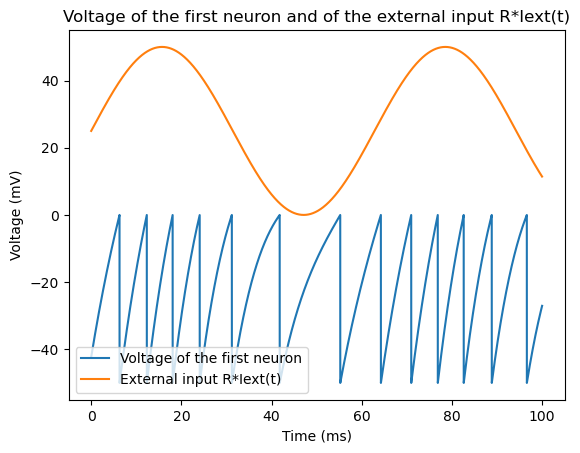

In [8]:
# Plot the voltage of the first neuron and the external input RIext(t)
plt.plot(np.arange(len(potentials0))*dt0/b2.ms, potentials0[:,0]/b2.mV, label='Voltage of the first neuron')
plt.plot(np.arange(len(input_current0.values))*input_current0.dt/b2.ms, R*input_current0.values/b2.mV, label='External input R*Iext(t)')
plt.title('Voltage of the first neuron and of the external input R*Iext(t)')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.show()

2. Plot the low-pass filtered activity of the population, using a time bin of $τ_A = 1\>\mathrm{ms}$. Make the corresponding raster plot.

In [9]:
def low_pass_filtering(activity : list, dt : b2.ms, tau_A : b2.ms):
    """apply a low-pass filter to the activity of a neuron

    Args:
        activity (b2.TimedArray): the activity of the neuron
        dt (b2.ms): time interval between two timesteps
        tau_A (b2.ms): the width of the time bin. 

    Returns:
        list: the filtered activity
    """
    tau_A = int(tau_A / dt) + 1 # convert time into #timestep, add 1 to include the timestep t=0
    return np.convolve(activity, np.ones(tau_A)/tau_A, mode='same')

def network_activity(spikes : list, dt : b2.ms):
    """compute the network activity of a population of neurons

    Args:
        spikes (list): the spiking activity of each neuron
        dt (b2.ms): time interval between two timesteps

    Returns:
        list: the network activity of the population for each timestep
    """
    return np.sum(spikes, axis=1) / len(spikes[0]) / (dt/b2.second)

In [10]:
def activity_plot(activity : list, dt : b2.ms):
    """plot the network activity of a population of neurons

    Args:
        activity (list): the spiking activity of each neuron
        dt (b2.ms): time interval between two timesteps
    """
    plt.figure(figsize=(10, 5))
    plt.plot(np.arange(len(activity))*dt/b2.ms, activity)
    plt.title('Network activity A(t)')
    plt.xlabel('Time (ms)')
    plt.ylabel('Activity (Hz)')
    plt.show()
    
def compute_spiking_times(spikes : list, dt : b2.ms):
    """compute the spiking times of a population of neurons

    Args:
        spikes (list): the spiking activity of each neuron
        dt (b2.ms): dt of the simulation

    Returns:
        list: the spiking times of each neuron
    """
    spiking_times = []
    for neuron in range(len(spikes[0])):
        spiking_times.append(np.where(spikes[:, neuron])[0] * dt / b2.ms)
    return spiking_times
    
def raster_plot(spiking_times : list, start_time : b2.ms = 0*b2.ms, end_time : b2.ms = None, title : str = 'Raster plot of the spikes of the neurons'):
    """plot the raster plot of a population of neurons

    Args:
        spiking_times (list): the spiking times of each neuron
        start_time (b2.ms, optional): the time at which the raster plot starts. Defaults to 0*b2.ms.
        end_time (b2.ms, optional): the time at which the raster plot ends. Defaults to Tf.
        title (str, optional): the title of the plot. Defaults to 'Raster plot of the spikes of the neurons'.
        
    Returns:
        list: the spiking times of each neuron
    """
    plt.figure(figsize=(10, 5))
    for neuron in range(len(spiking_times)):
        plt.scatter(spiking_times[neuron], neuron*np.ones(len(spiking_times[neuron])), color='black')
    plt.title(title)
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron #')
    if end_time is None: plt.xlim(left = start_time/b2.ms)
    else: plt.xlim(start_time/b2.ms, end_time/b2.ms)
    plt.show()

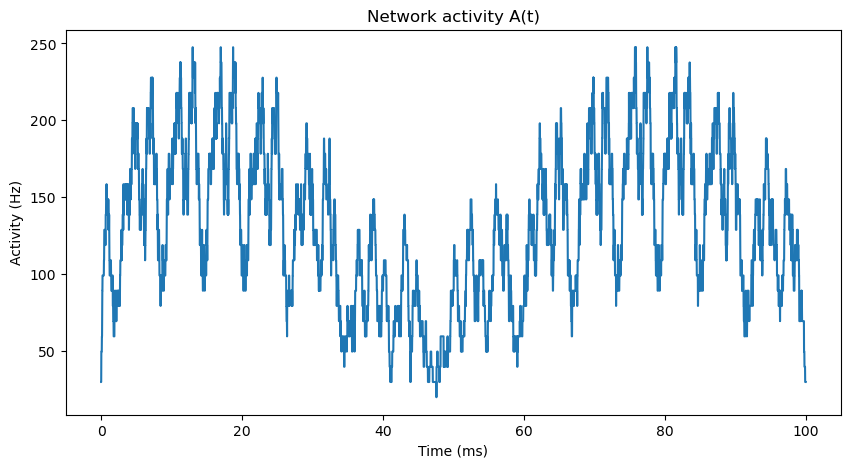

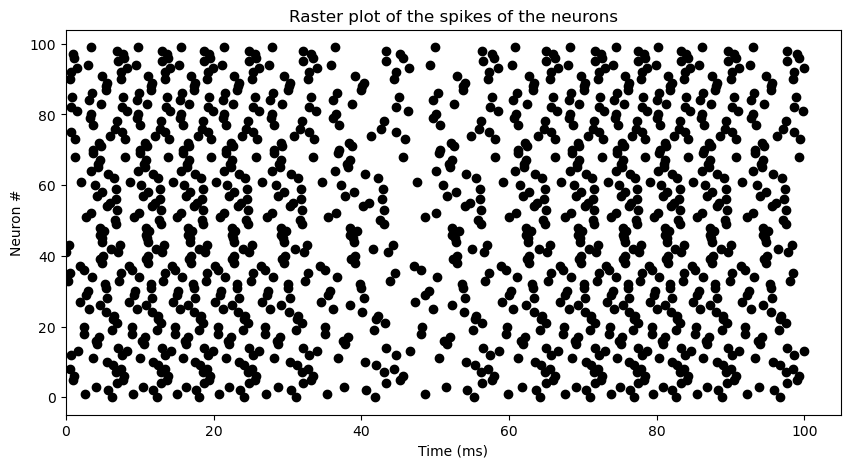

In [11]:
activity0 = low_pass_filtering(network_activity(spikes0, dt0), dt0, tau_A=1*b2.ms)
activity_plot(activity0, dt0)
raster_plot(compute_spiking_times(spikes0, dt0))

## Exercise 1: Observation of the synchronous state

In [12]:
# Define the parameters
delta = 5*b2.ms
tau_epsilon = 2*b2.ms
J = 20*b2.mV

Tf1=600*b2.ms
dt1=0.01*b2.ms

input_current1 = np.zeros(int(Tf1/dt1)+1) * b2.mA
N=100
np.random.seed(24)
v_t0 = np.random.uniform(v_reset, eta, N) * b2.volt
epsilonA_0 = 0*b2.Hz
epsilonB_0 = 0*b2.Hz

### Implementation of the interaction

We now add the interaction between neurons.
1. Implement a method that integrates numerically eq.$(4)$ and eq.$(5)$, given initial conditions $v_i(0)$, and
$ϵ_{A,B}(0)$.

In [13]:
def next_epsilon(eA_prev : b2.Hz, eB_prev : b2.Hz, spikes_prev : np.array, dt : b2.ms, tau_epsilon : b2.ms = tau_epsilon):
    """compute the next value of epsilonA and epsilonB

    Args:
        eA_prev (b2.Hz): previous value of epsilonA
        eB_prev (b2.Hz): previous value of epsilonB
        spikes_prev (np.array): array of the spikes of the neurons at the previous timestep
        dt (b2.ms): timestep of the simulation
        tau_epsilon (b2.ms, optional): rise time of the kernel function. Defaults to tau_epsilon.

    Returns:
        float, float: the next values of epsilonA and epsilonB
    """
    epsilonA = eA_prev + (-eA_prev + eB_prev) * (dt/tau_epsilon)
    epsilonB = eB_prev - (eB_prev * dt + np.sum(spikes_prev)/len(spikes_prev)) / tau_epsilon 
    return epsilonA, epsilonB

def next_potential_spikes(v_prev : np.array, epsilonA : b2.Hz, dt : b2.ms, I_ext : b2.mA, v_rest : b2.mV = v_rest, R : b2.ohm = R, tau_m : b2.ms = tau_m, J : b2.mV = J, v_reset : b2.mV = v_reset, beta : b2.Hz = beta):
    """compute the membrane potential and the spikes of a population of neurons at the next timestep

    Args:
        v_prev (np.array): array of the membrane potentials of the neurons at the previous timestep
        epsilonA (b2.Hz): value of epsilonA at the previous timestep
        dt (b2.ms): timestep of the simulation
        I_ext (b2.mA): external current applied to the neurons
        v_rest (b2.mV, optional): membrane potential at rest. Defaults to v_rest.
        R (b2.ohm, optional): membrane resistance. Defaults to R.
        tau_m (b2.ms, optional): membrane time constant. Defaults to tau_m.
        J (b2.mV, optional): the interaction strength. Defaults to J.
        v_reset (b2.mV, optional): the reset potential (after a spike). Defaults to v_reset.
        beta (b2.Hz, optional): the firing rate of the neurons. Defaults to beta.

    Returns:
        np.array, np.array: the membrane potentials and the spikes of the neurons at the next timestep
    """
    potentials, spikes = [], []
    for neuron in range(N):
        v_next = v_prev[neuron] - (dt/tau_m) * (v_prev[neuron] - v_rest - R*I_ext) + dt * J * epsilonA
        spikes.append(is_spike(v_next, dt, beta=beta))
        if spikes[-1]:
            v_next = v_reset
        potentials.append(v_next.copy())
    return potentials, spikes


def compute_potentials1(v_t0 : np.array, epsilonA_0 : b2.Hz, epsilonB_0 : b2.Hz, Tf : b2.ms, dt : b2.ms, I_ext : np.array, v_rest : b2.mV = v_rest, R : b2.ohm = R, tau_m : b2.ms = tau_m, J : b2.mV = J, v_reset : b2.mV = v_reset, beta : b2.Hz = beta):
    """compute the potentials and the spikes of the neurons in a self-interacting population

    Args:
        v_t0 (np.array): initial potentials of the neurons
        epsilonA_0 (b2.Hz): initial value of epsilonA
        epsilonB_0 (b2.Hz): initial value of epsilonB
        Tf (b2.ms): end time of the simulation
        dt (b2.ms): timestep of the simulation
        I_ext (np.array, optional): the external input current.
        v_rest (b2.mV, optional): the resting potential of the neurons. Defaults to v_rest.
        R (b2.ohm, optional): the membrane resistance. Defaults to R.
        tau_m (b2.ms, optional): the membrane time constant. Defaults to tau_m.
        J (b2.mV, optional): the interaction strength. Defaults to J.
        v_reset (b2.mV, optional): the reset potential. Defaults to v_reset.
        beta (b2.Hz, optional): the firing rate of the neurons. Defaults to beta.

    Returns:
        list, list: the potentials and the spikes of the neurons
    """
    potentials = [v_t0.copy()]
    spikes = [[0] * len(v_t0)]
    epsilonA = [epsilonA_0] * int(delta/dt)
    e_B = epsilonB_0
    
    for k in range(1, int(Tf/dt) + 1):
        # Compute the next epsilonA and epsilonB
        e_A, e_B = next_epsilon(epsilonA[-1], e_B, spikes[k-1], dt)
        epsilonA.append(e_A)
        
        # Compute the next potential for each neuron
        v_next, spikes_next = next_potential_spikes(potentials[k-1], epsilonA[k-1], dt, I_ext[k-1], v_rest, R, tau_m, J, v_reset, beta)
        potentials.append(v_next.copy())
        spikes = np.vstack((spikes, spikes_next.copy()))
    return np.array(potentials), spikes

### Spontaneous dynamics of the system

2. Starting from the random uniform initial voltage distribution $v_i(0) ∼ \mathcal{U}([v0 , η[)$, and $ϵ_A(0) = ϵ_B(0) =
0$, simulate the evolution of the system for $t ≤ T_f = 600\>\mathrm{ms}$.

    1. Make a plot of the activity (low-passed with $τ_A = 0.5\>\mathrm{ms}$) and a raster plot, for the first $200\>\mathrm{ms}$ and last $30\>\mathrm{ms}$ of the evolution. \
    Why is the activity composed of sharp oscillations/peaks?
    2. Compute the period $T$ between two peaks.
    3. How would the network behave as $t → ∞$?

In [14]:
potentials1, spikes1 = compute_potentials1(v_t0, epsilonA_0, epsilonB_0, Tf1, dt1, I_ext = input_current1)

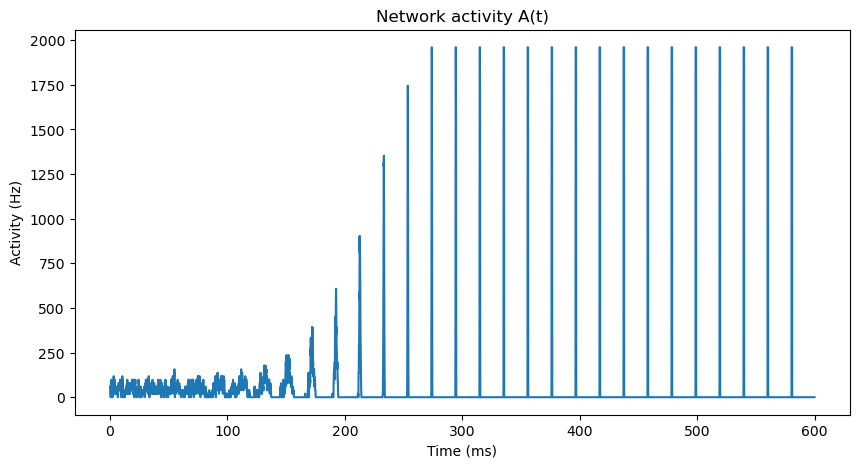

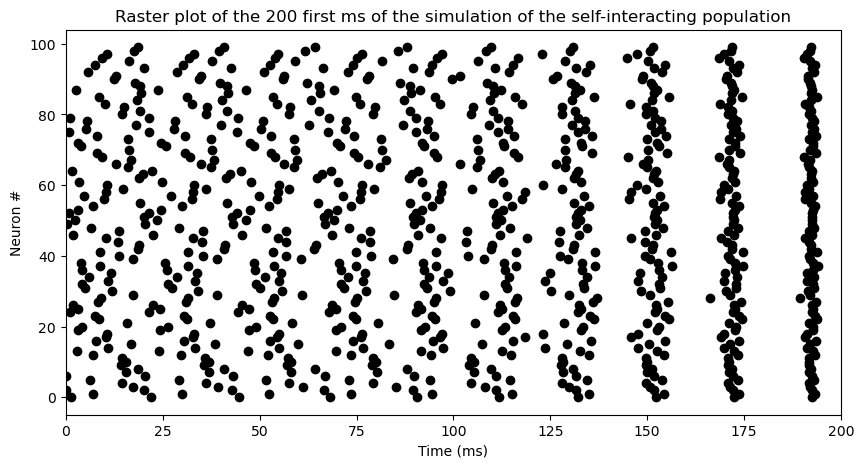

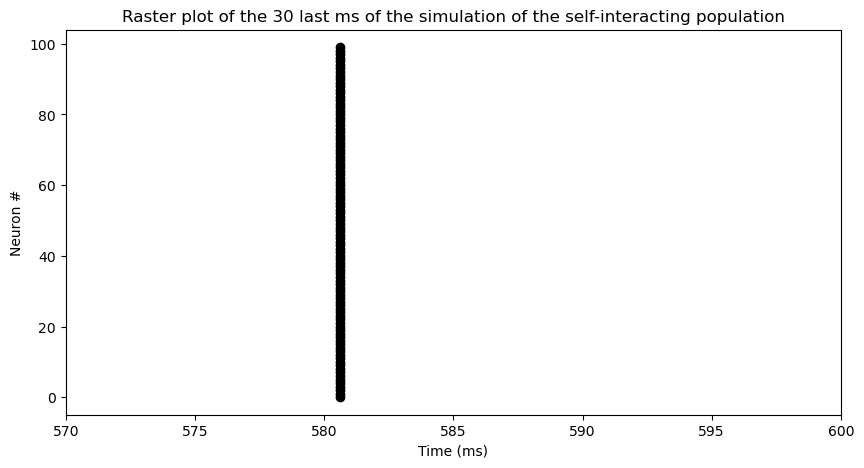

In [15]:
activity1 = low_pass_filtering(network_activity(spikes1, dt1), dt1, tau_A=0.5*b2.ms)
activity_plot(activity1, dt1)
spiking_times1 = compute_spiking_times(spikes1, dt1)
raster_plot(spiking_times1, end_time=200*b2.ms, title="Raster plot of the 200 first ms of the simulation of the self-interacting population")
raster_plot(spiking_times1, start_time=Tf1-30*b2.ms, end_time = Tf1, title="Raster plot of the 30 last ms of the simulation of the self-interacting population")

In [16]:
from scipy.signal import find_peaks

# Extract peaks of the activity
peaks, _ = find_peaks(activity1, height=1000)
peaks = peaks * (dt1/b2.ms)
T_peaks = np.mean([t - s for s, t in zip(peaks, peaks[1:])])
print("The period between two peaks of spiking activity : {} ms in average".format(T_peaks))

The period between two peaks of spiking activity : 13.367307692307692 ms in average


3. Now consider a constant external input current $I_{\text{ext}}(t) = I_0 = −0.25\>\mathrm{mA}$.
    1. Repeat Qu.1.2. What state does the system converge to now? What is different from the synchronous
    state observed previously?
    2. Have a look at eq.$(4)$. What is the corresponding value of $v_{\text{rest}}$, for which the dynamics would be
    the same without any external input?

In [17]:
I0 = -0.25*b2.mA
input_current2 = np.full(int(Tf1/dt1)+1, I0/b2.mA) * b2.mA

In [18]:
potentials2, spikes2 = compute_potentials1(v_t0, epsilonA_0, epsilonB_0, Tf1, dt1, I_ext = input_current2)

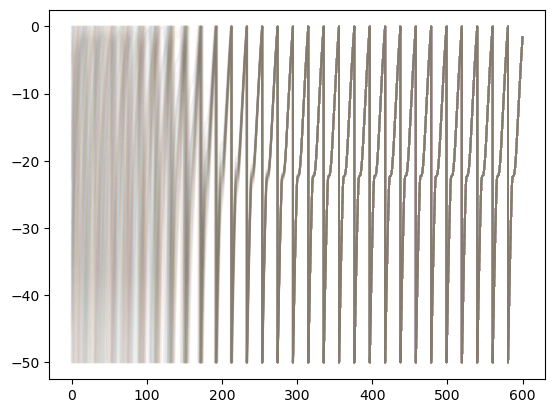

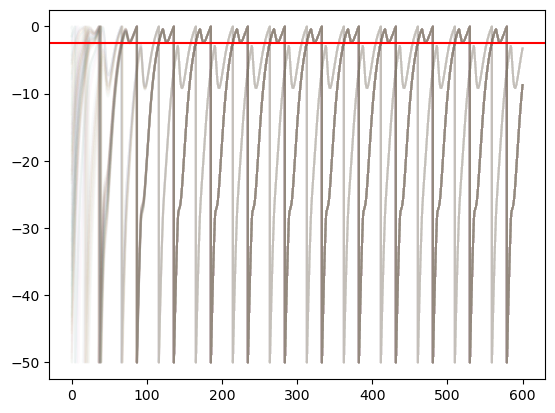

In [19]:
for neuron in range(N):
    plt.plot(np.arange(len(potentials1))*dt1/b2.ms, potentials1[:, neuron]/b2.mV, alpha=0.02)
plt.show()

for neuron in range(N):
    plt.plot(np.arange(len(potentials2))*dt1/b2.ms, potentials2[:, neuron]/b2.mV, alpha=0.02)
plt.axhline(y=(-v_rest-R*I0)/b2.mV, color='red', label='Steady-state potential : -(v_rest + R*I0)')
plt.show()


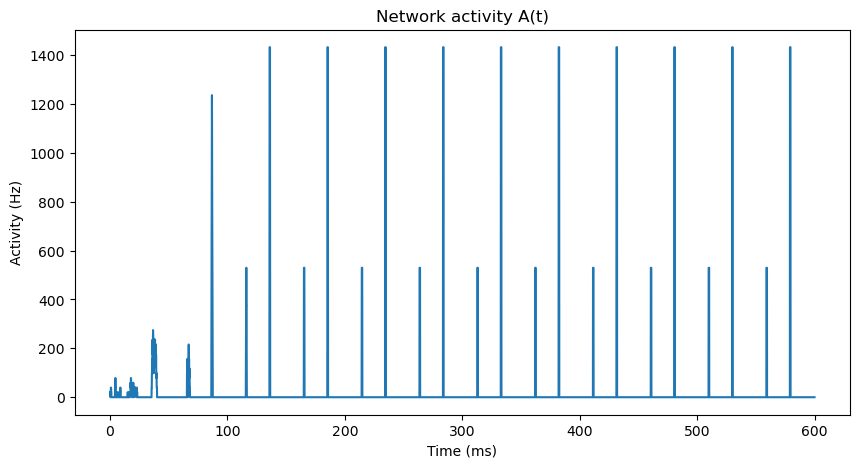

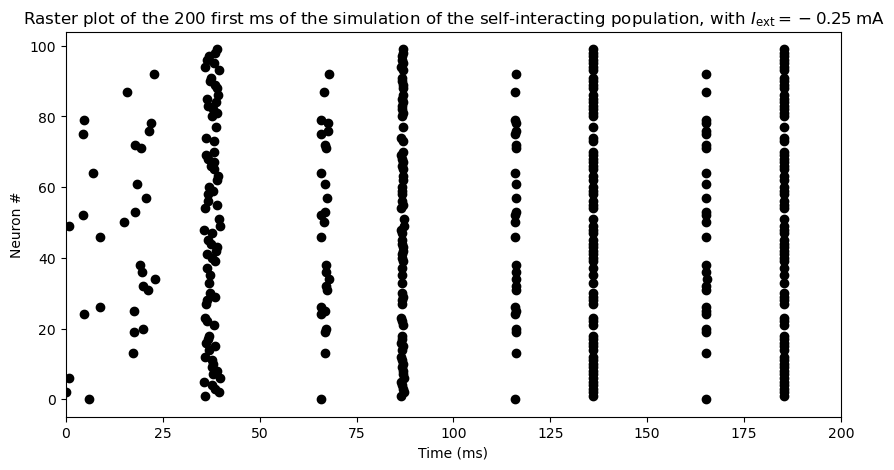

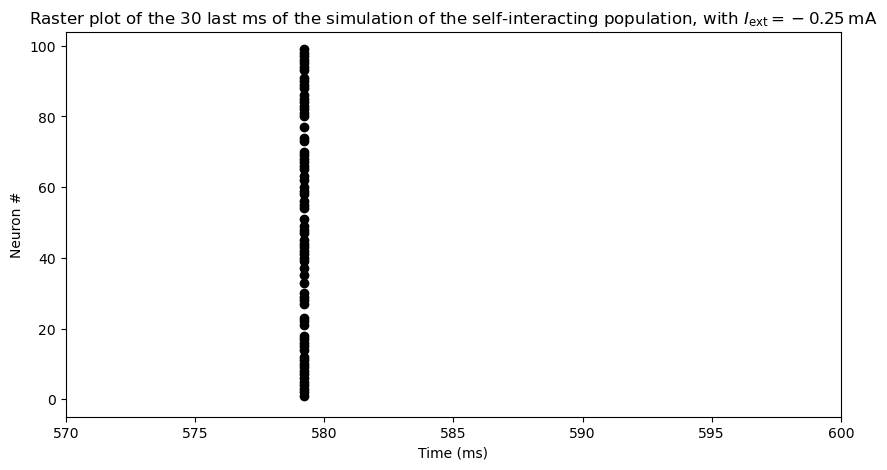

In [20]:
activity2 = low_pass_filtering(network_activity(spikes2, dt1), dt1, tau_A=0.5*b2.ms)
activity_plot(activity2, dt1)
spiking_times2 = compute_spiking_times(spikes2, dt1)
raster_plot(spiking_times2, end_time=200*b2.ms, title="Raster plot of the 200 first ms of the simulation of the self-interacting population, with $I_{\mathrm{ext}} = -0.25\>\mathrm{mA}$")
raster_plot(spiking_times2, start_time=Tf1-30*b2.ms, end_time = Tf1, title="Raster plot of the 30 last ms of the simulation of the self-interacting population, with $I_{\mathrm{ext}} = -0.25\>\mathrm{mA}$")

## Exercise 2: Transition between states

We will now visualise the transition between the synchronous state that you observed in Qu.1.2, and the other one that appeared in Qu.1.3. \
To do this, we will extract the _relative firing times_ of the neurons w.r.t. the first neuron. For each firing time of the first neuron $t̂^f_1$ and a given neuron $n$, it is defined as the time interval until the next firing of this neuron:
$$
∆t^f_{1,n}(t̂^f_1) \coloneqq \min\{t̂^{f^\prime}_n \mathrel\mid t^{f^\prime}_n > t̂^f_1 \} − t^f_1
$$

1. Implement a method that extracts the relative firing times of the neurons.
    1. For the time evolution of Qu.1.3, make a plot of the relative firing times $∆t^f_{1,n}(t̂^f_1)$ for $n = 2, \dots, N$, along with the inter-spike intervals of the reference neuron, $∆t^f_{1,1}(t̂^f_1) = t̂^{f + 1}_1 − t̂^f_1$.
    2. How does the synchronisation look like in this representation? How do you read the number of clusters in the synchronous state?

In [21]:
def relative_firing_times(spikes : np.ndarray, dt : b2.ms, ref_neuron : int = 0, include_last : bool = False):
    """Extract the relative firing times of a collection of neurons.

    Args:
        spikes (np.array): 2D binary array of the firing spikes of each neuron. 
        dt (b2.ms): timestep of the simulation.
        ref_neuron (int): index of the neuron to use as reference for calculating the relative spikes.
        include_last (bool): whether or not to include the values calculated relative to the last spike of the reference neuron.
            Most neurons will have finished firing so most of these values will be 0.

    Returns:
        np.ndarray: array of size n_valid_spikes, containing the firing times of the chosen reference neuron.
        np.ndarray: array of size n_valid_spikes x n_neurons, containing the firing times of each neuron relative to the spikes of the reference neuron.
    """
    # Initialize output array
    relative_spikes = []
    # Get positions of spikes of the reference neuron
    ref_spikes = np.where(spikes[:, ref_neuron])[0]

    for ref_spike in ref_spikes:
        # Next spike for each neuron (shortcut with argmax, which returns the first position)
        next_spikes = np.argmax(spikes[ref_spike+1:, :], axis=0)

        # Test if all positions correspond to a spike (verification after argmax, which returns 0 if there are no more spikes)
        # If include_last is True, the test is skipped.
        if include_last or np.all(spikes[ref_spike+1+next_spikes, :].diagonal()):
            relative_spikes.append(next_spikes)

    return ref_spikes[:len(relative_spikes)] * dt, np.array(relative_spikes) * dt

In [22]:
ref_spikes2, rel_spikes2 = relative_firing_times(spikes2, dt1)

In [23]:
def relative_spike_plot(relative_spikes, spiking_times, ref_neuron : int = 0,
                        title : str = 'Relative firing time of all neurons over simulation time'):
    """plot the raster plot of a population of neurons

    Args:
        spiking_times (list): the spiking times of each neuron
        start_time (b2.ms, optional): the time at which the raster plot starts. Defaults to 0*b2.ms.
        end_time (b2.ms, optional): the time at which the raster plot ends. Defaults to Tf.
        title (str, optional): the title of the plot. Defaults to 'Raster plot of the spikes of the neurons'.
        
    Returns:
        list: the spiking times of each neuron
    """
    intervals = relative_spikes[:, ref_neuron]
    relative_spikes = b2.concatenate((relative_spikes[:, :ref_neuron], relative_spikes[:, ref_neuron+1:]), axis=1)
    plt.figure(figsize=(10, 5))
    for spiking_time, interval, next_spikes in zip(spiking_times/b2.ms, intervals/b2.ms, relative_spikes/b2.ms):
        plt.scatter(spiking_time*np.ones_like(next_spikes), next_spikes, marker="x", color="black")
        plt.scatter(spiking_time, interval, color="red")
    plt.title(title)
    plt.xlabel(f'Reference neuron firing time ($t̂^f_{{{ref_neuron+1}}}$, in ms)')
    plt.ylabel(f'Relative firing time ($∆t^f_{{{ref_neuron+1},n}}$, in ms)\nReference neuron inter-spike interval in red')
    plt.show()

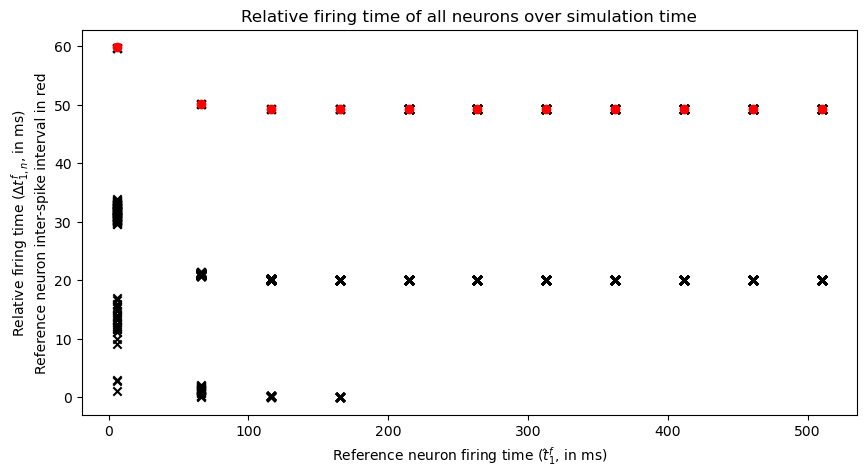

In [24]:
relative_spike_plot(rel_spikes2, ref_spikes2)

2. Consider the step external input $I_{\text{ext}}(t) = I_0 \cdot \mathbb{1}_{\{t>T_{\text{step}}\}}$, with $I_0 = −0.25\>\mathrm{mA}$, $T_{\text{step}} = 500\>\mathrm{ms}$. \
Using the same initial conditions as in Qus.1.2 and 1.3, run the time evolution for $t ≤ T_f = 1000\>\mathrm{ms}$.
    1. Make the corresponding plot of the relative firing times.
    2. Why does the system switch from one state to another at $t = T_{\text{step}}$?

In [25]:
Tf3=1000*b2.ms
Tstep3=500*b2.ms

input_current3 = np.zeros(int(Tf3/dt1)+1) * b2.mA
input_current3[int(Tstep3/dt1)+1:] = I0

In [27]:
potentials3, spikes3 = compute_potentials1(v_t0, epsilonA_0, epsilonB_0, Tf3, dt1, I_ext = input_current3)

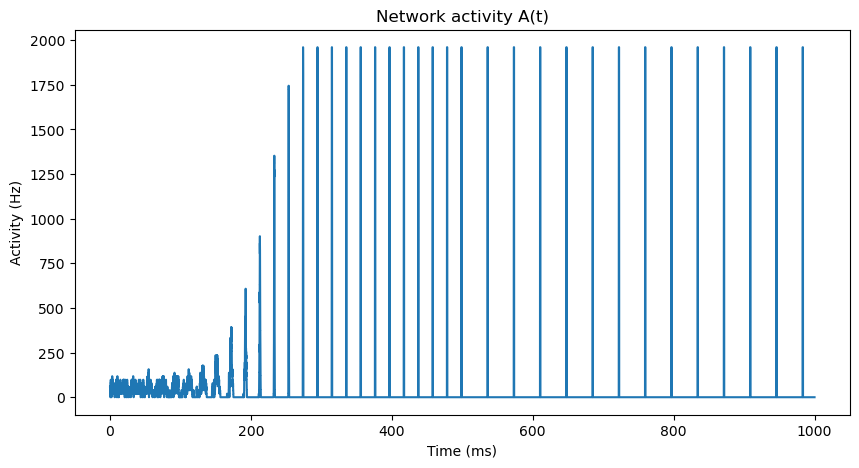

In [ ]:
activity3 = low_pass_filtering(network_activity(spikes3, dt1), dt1, tau_A=0.5*b2.ms)
activity_plot(activity3, dt1)

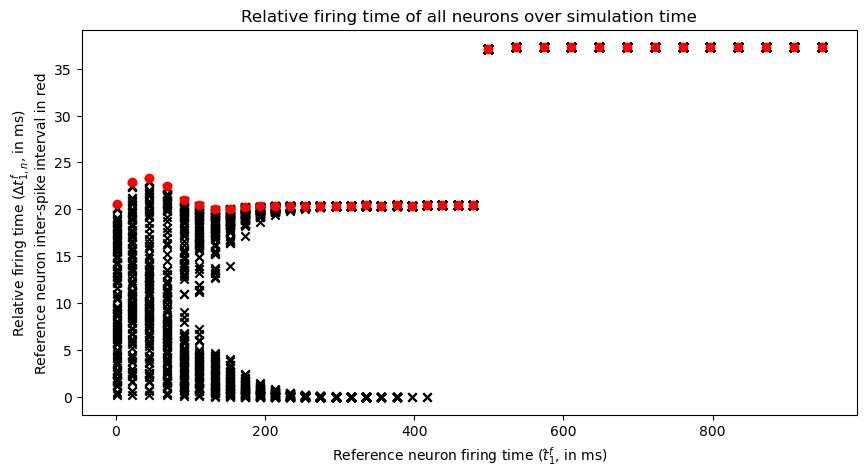

In [ ]:
ref_spikes3, rel_spikes3 = relative_firing_times(spikes3, dt1)
relative_spike_plot(rel_spikes3, ref_spikes3)

We will now estimate the critical value of $v_{\text{rest}}$ at which the transition happens.

3. In this question, set the noise parameter to $β^\prime = 25\>\mathrm{ms^{−1}}$. \
Compute the critical value $I_c$ of the external input at which the switch happens. To do this, set initially the system in the synchronous state, and run the time evolution for $t ≤ T_f = 2000\>\mathrm{ms}$, with the external
input $I_{\text{ext}}(t) = I_0 \cdot t/T_f$.
    1. Make the corresponding plot of the relative firing times.
    2. Estimate on the plot the time $t_c$ at which neurons start to get away from the synchrony, and thus
    the critical current $I_c = I_{\text{ext}}(t_c)$. What is the corresponding critical value of $v_{\text{rest}}$?

In [ ]:
Tf4=2000*b2.ms
beta4 = 25/b2.ms

input_current4 = b2.arange(0 * b2.mA, I0, I0*dt1/Tf4)

In [ ]:
potentials4, spikes4 = compute_potentials1(v_t0, epsilonA_0, epsilonB_0, Tf4, dt1, I_ext=input_current4, beta=beta4)

In [ ]:
activity4 = low_pass_filtering(network_activity(spikes4, dt1), dt1, tau_A=0.5*b2.ms)
activity_plot(activity4, dt1)

NameError: name 'low_pass_filtering' is not defined

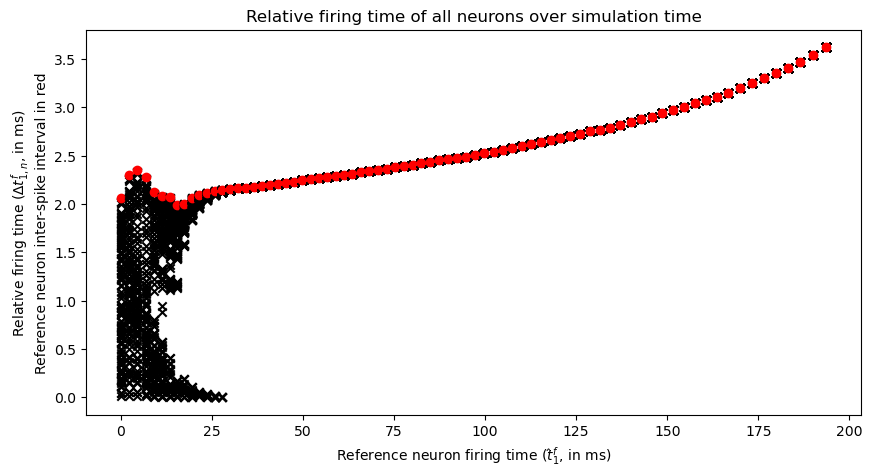

In [ ]:
ref_spikes4, rel_spikes4 = relative_firing_times(spikes4, dt1)
relative_spike_plot(rel_spikes4, ref_spikes4)

## Exercise 3: Stability of the synchronous state

### Dilation factor

1. Compute the dilation factor $c$ of the synchronous state observed in Qu.1.2. To do this:
    1. set initially the system in the synchronous state, and add a small perturbation (a few $\mathrm{mV}$) on the voltage of a single neuron $n$,
    2. compute the firing delays $∆t_f$ for ∼10 firings (i.e. $∼100\>\mathrm{ms}$),
    3. estimate the dilation factor $c$, by doing a linear fit of $\log(∆t_f)$ as a function of $f$. Plot $\log(∆t_f)$, as well as the fit that corresponds.

2. Answer without making new computations.
    1. What is the condition on $c$ so that the synchronous state is stable?
    2. How would $c$ change if we inject an external current $I_{\text{ext}} = I_0 = −0.25\>\mathrm{mA}$?
    3. Can you explain better what you observed in Qus.1.2 and 1.3?

3. Let the population in the synchronous state send its input to an second population of $N^\prime = 100$ non-interacting neurons. \
Run the time evolution of the system, with uniform initial voltage distribution for the second population, for $t ≤ T_f = 500\>\mathrm{ms}$. Plot the relative firing times of the neurons of the non-interacting population, with respect to the firing times of a neuron in the synchronous population.

4. Answer without making new computations.
    1. What is the link between a synchronous population of interacting neurons in which one neuron gets perturbed, and a population of $N^\prime$ non-interacting neurons receiving the input from the synchronous population?
    2. Evaluate the time interval around a synchronous firing that delimits its region of attraction. \
    What happens if a neuron fires at the boundary of two regions?

5. **BONUS:** You know the external input current that elicits states with one or two clusters. How do their properties (period, stability, ...) change if you consider a smaller network of $N = 10$ neurons? $N = 5$, $N = 1$? Motivate your answer with additional simulations.